# Clustering Assignment

In [475]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import datetime as dt

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [476]:
# Reading the data
df=pd.read_csv('Country-data.csv')

In [477]:
# coping df to another dataframe data
data=df.copy()

In [478]:
# Modifing the exports, imports, health features to values of GDP instead of percentages
data.exports=df.exports*df.gdpp/100
data.imports=df.imports*df.gdpp/100
data.health=df.health*df.gdpp/100

In [479]:
data.shape

(167, 10)

EDA

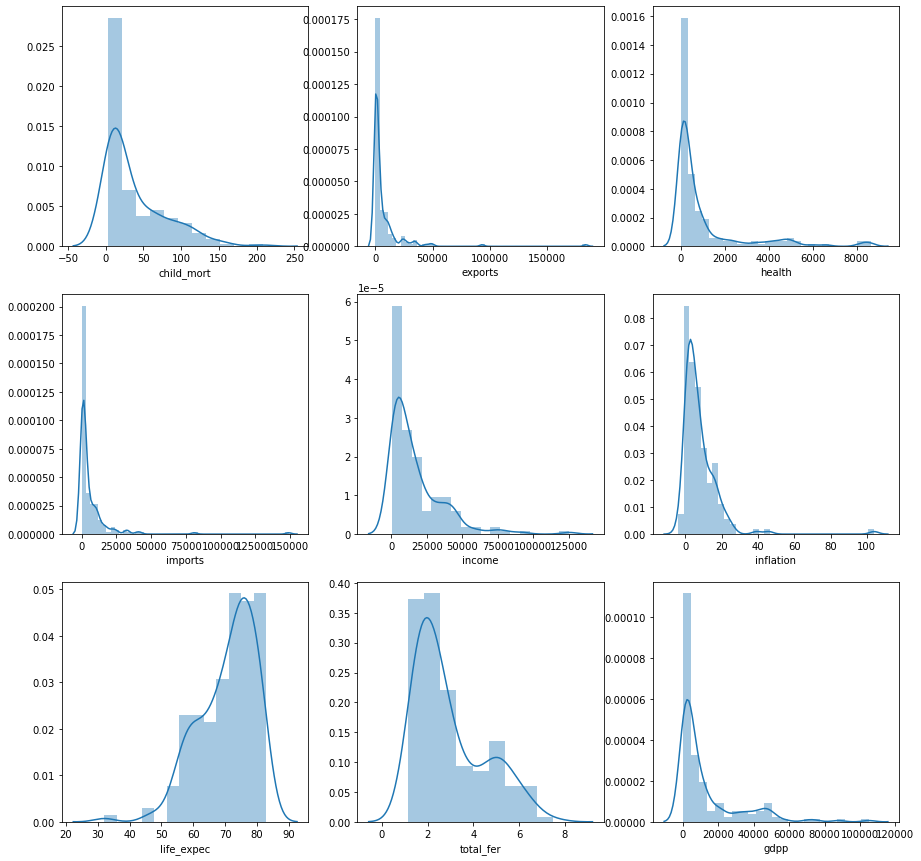

In [480]:
#understanding the distribution of numerical feature in the data 
plt.figure(figsize = (15,15))
feature = data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.distplot(data[i[1]])

- Description : Most of the distributions are skewed right, which means features has outliers at higher range

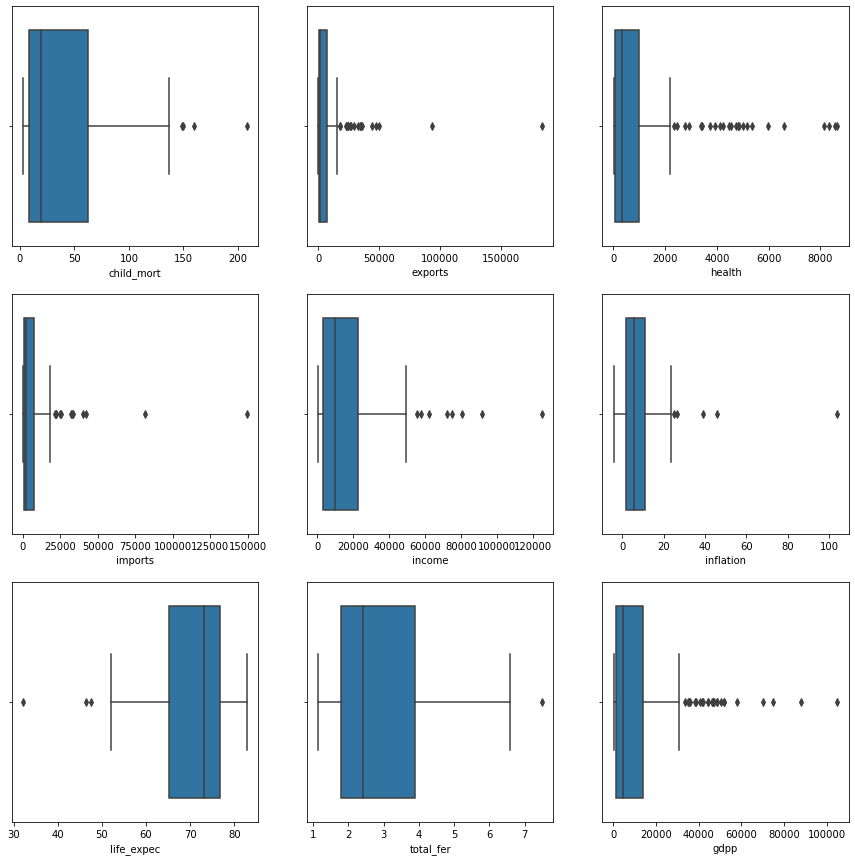

In [481]:
# distribution of features by boxplot and figuring outliers
plt.figure(figsize = (15,15))
feature = data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(data[i[1]],)

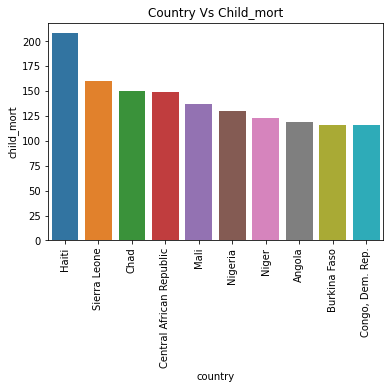

In [482]:
# Top 10 countries with high Child Mortality rate
ch_mort10=data.sort_values(by='child_mort',ascending=False).head(10)
plt.xticks(rotation=90)
sns.barplot(x='country',y='child_mort',data=ch_mort10)
plt.title('Country Vs Child_mort')
plt.show()

- Observation: Among all countries, Haiti has the high Child Mortality rate

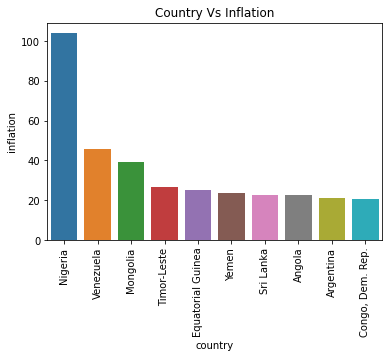

In [483]:
# Top 10 countries with high Inflation rate
inf10=data.sort_values(by='inflation',ascending=False).head(10)
plt.xticks(rotation=90)
sns.barplot(x='country',y='inflation',data=inf10)
plt.title('Country Vs Inflation')
plt.show()

- Observation: Among all countries, Nigeria has the high Inflation rate

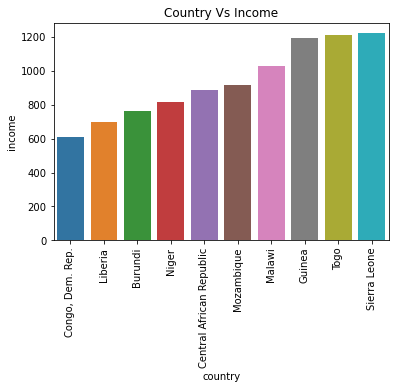

In [484]:
# Top 10 countries with least per capita Income
ppi10=data.sort_values(by='income',ascending=True).head(10)
plt.xticks(rotation=90)
sns.barplot(x='country',y='income',data=ppi10)
plt.title('Country Vs Income')
plt.show()

- Observation: Among all countries, Congo, Republic has the least per capita Income

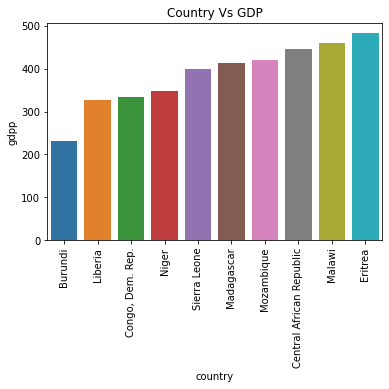

In [485]:
# Top 10 countries with least GDP
gdp10=data.sort_values(by='gdpp',ascending=True).head(10)
plt.xticks(rotation=90)
sns.barplot(x='country',y='gdpp',data=gdp10)
plt.title('Country Vs GDP')
plt.show()

- Observation: Among all countries, Burundi has lowest GDP

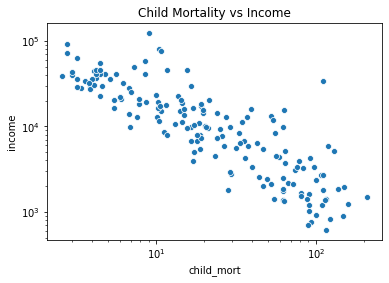

In [486]:
# Plot the cluster
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(x = 'child_mort', y = 'income' , data = data, palette = 'Set1')
plt.title('Child Mortality vs Income')
plt.show()

- Observation : Negative Corelation between Child Mortality and Income, C. Mortality is high at low percapita income

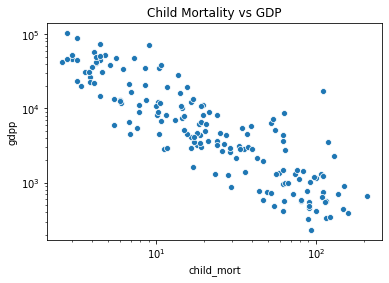

In [487]:
# Plot the cluster
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(x = 'child_mort', y = 'gdpp', data = data, palette = 'Set1')
plt.title('Child Mortality vs GDP')
plt.show()

- Observation : Negative Corelation between Child Mortality and GDP, C. Mortality is high at low GDP countries.

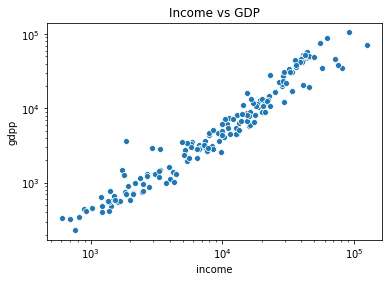

In [488]:
# Plot the cluster
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(x = 'income', y = 'gdpp',  data = data, palette = 'Set1')
plt.title('Income vs GDP')
plt.show()

- Observation : Positive Corelation between Income and GDP, Percapita income is high for high GDP countries. 

In [489]:
data.exports.describe(percentiles=[0.05,0.10,0.25,.75,.80,.85,.90,.95,.96,.97,.98,.99])

count       167.000000
mean       7420.618847
std       17973.885795
min           1.076920
5%           70.468800
10%         110.224800
25%         447.140000
50%        1777.440000
75%        7278.000000
80%       10194.960000
85%       12667.230000
90%       17760.600000
95%       31385.100000
96%       34258.200000
97%       36367.618000
98%       46480.928000
99%       64794.260000
max      183750.000000
Name: exports, dtype: float64

## Outlier Treatment

- Outliers of 'health', 'income', 'gdpp', 'exports', 'imports' are replaced with Q3+1.5*InterQuartileRange and Q1-1.5*IQR

In [490]:
# capping
cols = ['health','income','gdpp','exports','imports']
for i in cols:
    
    q4 = data[i].quantile(0.75)
    IQR= data[i].quantile(0.75)-data[i].quantile(0.25)
    
    data[i][data[i]>= (q4+1.5*IQR)] = (q4+1.5*IQR)

In [491]:
# capping
cols = ['life_expec']
for i in cols:
    
    q4 = data[i].quantile(0.25)
    IQR= data[i].quantile(0.75)-data[i].quantile(0.25)
    
    data[i][data[i]<= (q4-1.5*IQR)] = (q4-1.5*IQR)

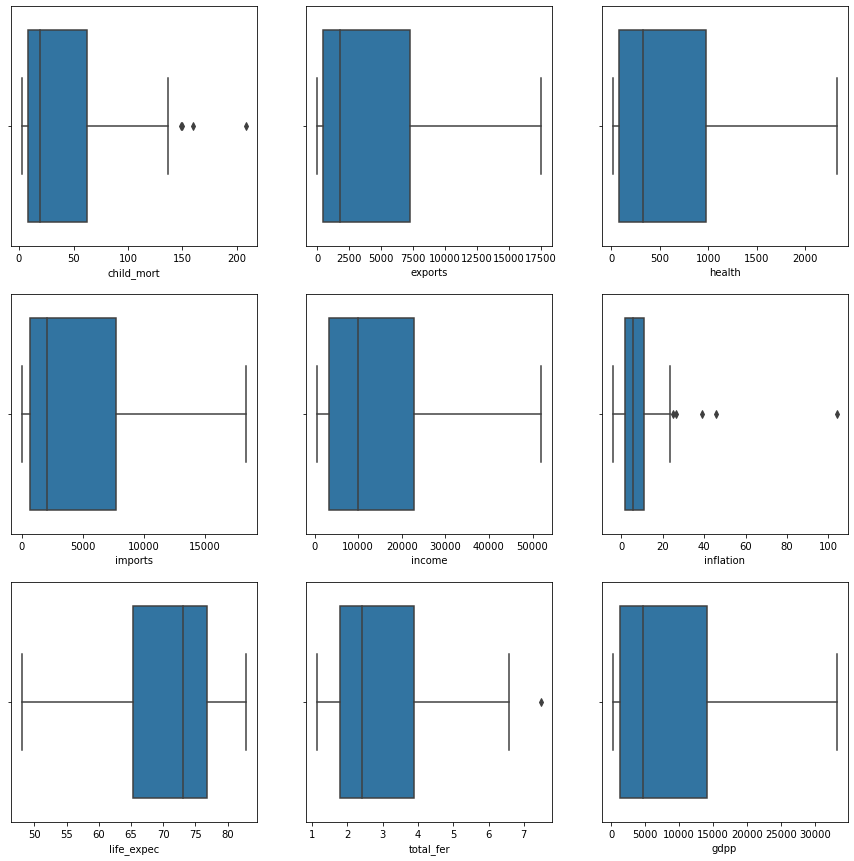

In [492]:
# Observing the Data after outlier treatment
plt.figure(figsize = (15,15))
feature = data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(data[i[1]],)

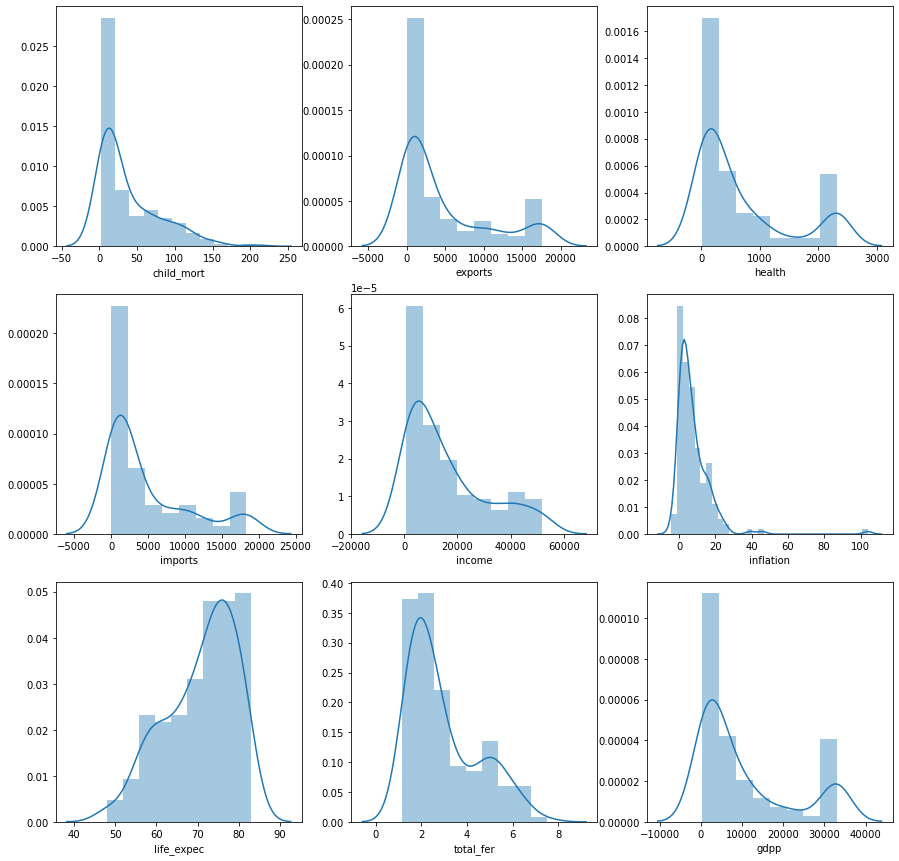

In [493]:
#understanding the distribution of numerical feature in the data 
plt.figure(figsize = (15,15))
feature = data.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.distplot(data[i[1]])

- Description : As the distribution of data is not completly normal, we go for Min Max scalling

In [494]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200


# Clustering

In [495]:
# Check the hopkins

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [496]:
# Hopkins Score 
hopkins(data.drop('country', axis = 1))

0.919978464506226

# Scaling

In [497]:
# scalling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1 = scaler.fit_transform(data.drop('country', axis = 1))
df1

array([[0.42648491, 0.00309436, 0.01258636, ..., 0.23453237, 0.73659306,
        0.00978753],
       [0.06815969, 0.06529185, 0.11033914, ..., 0.81294964, 0.07886435,
        0.1172984 ],
       [0.12025316, 0.09767404, 0.07490543, ..., 0.81870504, 0.27444795,
        0.12854494],
       ...,
       [0.10077897, 0.05376429, 0.0332145 , ..., 0.72086331, 0.12618297,
        0.03279735],
       [0.26144109, 0.02236594, 0.02380767, ..., 0.55971223, 0.55520505,
        0.03279735],
       [0.39191821, 0.03076622, 0.03165289, ..., 0.11366906, 0.670347  ,
        0.03735676]])

In [498]:
df1 = pd.DataFrame(df1, columns = df.columns[1:])
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.003094,0.012586,0.013505,0.019490,0.126144,0.234532,0.736593,0.009788
1,0.068160,0.065292,0.110339,0.108359,0.181489,0.080399,0.812950,0.078864,0.117298
2,0.120253,0.097674,0.074905,0.076333,0.239318,0.187691,0.818705,0.274448,0.128545
3,0.566699,0.125440,0.037973,0.082545,0.103021,0.245911,0.346763,0.790221,0.100277
4,0.037488,0.316718,0.312684,0.391817,0.360038,0.052213,0.827338,0.154574,0.363810


# K-Mean Clustering

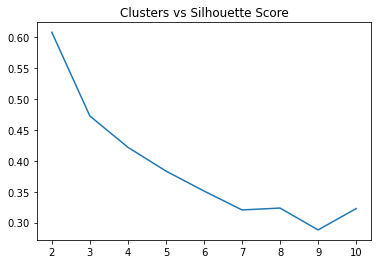

In [499]:
# Choose the value of K
# Silhouette score
# Elbow curve-ssd

from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ss.append([k, silhouette_score(df1, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])
plt.title('Clusters vs Silhouette Score')
plt.show()

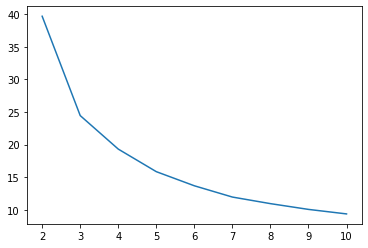

In [500]:
# Sum of squared distances
ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(df1)
    ssd.append([k, kmean.inertia_])
    
temp = pd.DataFrame(ssd)
plt.plot(temp[0], temp[1])

In [501]:
# K=3 as per Silhoutte graph and elbow curve
# Final Kmean Clustering

kmean = KMeans(n_clusters = 3, random_state = 50)
kmean.fit(df1)

KMeans(n_clusters=3, random_state=50)

In [502]:
df_kmean = df.copy()

In [503]:
# Creating label dataframe
label  = pd.DataFrame(kmean.labels_, columns= ['label'])
label.head()

,label
0,2
1,0
2,0
3,2
4,0


In [504]:
# Concatenating the labels to the actual data set
df_kmean = pd.concat([df_kmean, label], axis =1)
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


In [505]:
# checking the cluster count
df_kmean.label.value_counts()

0    84
2    43
1    40
Name: label, dtype: int64

## Cluster Profiling

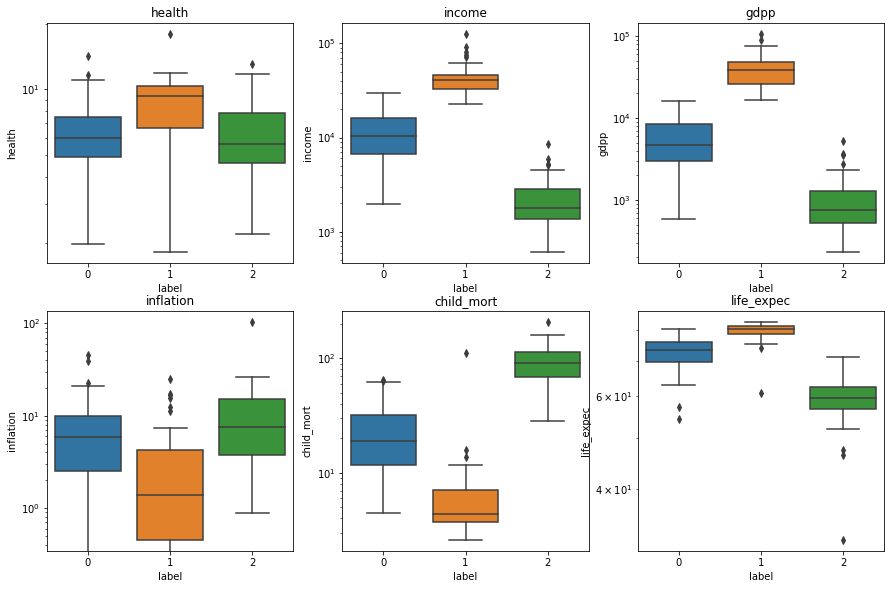

In [506]:
#Understaing the clusters vs Features to determine the charasteristics of the respective Cluster
plt.figure(figsize = (15,15))
feature = ['health','income','gdpp','inflation','child_mort','life_expec']
plt.yscale('log')
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    plt.yscale('log')
    plt.title(i[1])
    sns.boxplot(x='label',y=i[1],data=df_kmean)

In [507]:
# Making sense out of the clsuters
df_kmean[['child_mort','gdpp','income','label']].groupby('label').mean().reset_index()

,label,child_mort,gdpp,income
0,0,23.564286,5998.238095,11567.738095
1,1,8.305000,40337.500000,44787.500000
2,2,94.872093,1108.418605,2324.953488


- Observation : Cluster 2 has low GDP , low Percapita Income, and high Child mortality, which means Cluster 2 represents under developed countries.

In [508]:
df_kmean[df_kmean['label'] == 2].sort_values(by = ['gdpp','income','child_mort'], ascending = [True,False,True]).head(8)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,2
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,2
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,2
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,2
93,Madagascar,62.2,25.00,3.77,43.0,1390,8.79,60.8,4.60,413,2
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,2


- Recommended Countries - KMeans :
    1. Burundi
    2. Liberia
    3. Congo, Dem. Rep
    4. Niger
    5. Sierra Leone

## Hierarchical Clustering

In [509]:
df1.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.003094,0.012586,0.013505,0.019490,0.126144,0.234532,0.736593,0.009788
1,0.068160,0.065292,0.110339,0.108359,0.181489,0.080399,0.812950,0.078864,0.117298
2,0.120253,0.097674,0.074905,0.076333,0.239318,0.187691,0.818705,0.274448,0.128545
3,0.566699,0.125440,0.037973,0.082545,0.103021,0.245911,0.346763,0.790221,0.100277
4,0.037488,0.316718,0.312684,0.391817,0.360038,0.052213,0.827338,0.154574,0.363810


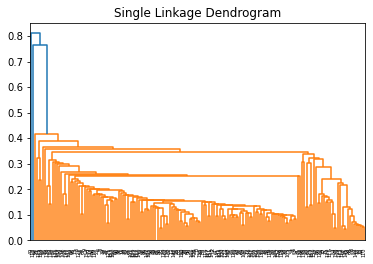

In [510]:
# single linkage
mergings = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings)
plt.title('Single Linkage Dendrogram')
plt.show()


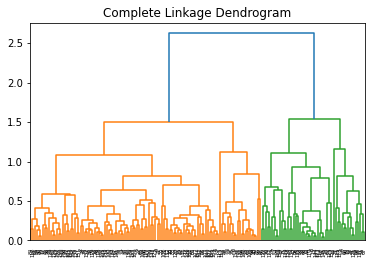

In [511]:
# complete linkage
mergings = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings)
plt.title('Complete Linkage Dendrogram')
plt.show()

In [512]:
# 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 2, 1, 1, 3, 3, 1, 3, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 0, 0, 1, 0, 3, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 0, 2, 3, 3,
       3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 1,
       0, 2, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 0,
       1, 2, 2, 3, 1, 1, 0, 2, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       3, 3, 0, 0, 3, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 1, 1, 2,
       0, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0])

In [513]:
# assign cluster labels
df_kmean['cluster_labels'] = cluster_labels
df_kmean.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,cluster_labels
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0,2


In [514]:
df_kmean.cluster_labels.value_counts()

1    94
3    36
0    21
2    16
Name: cluster_labels, dtype: int64

## Cluster Profiling

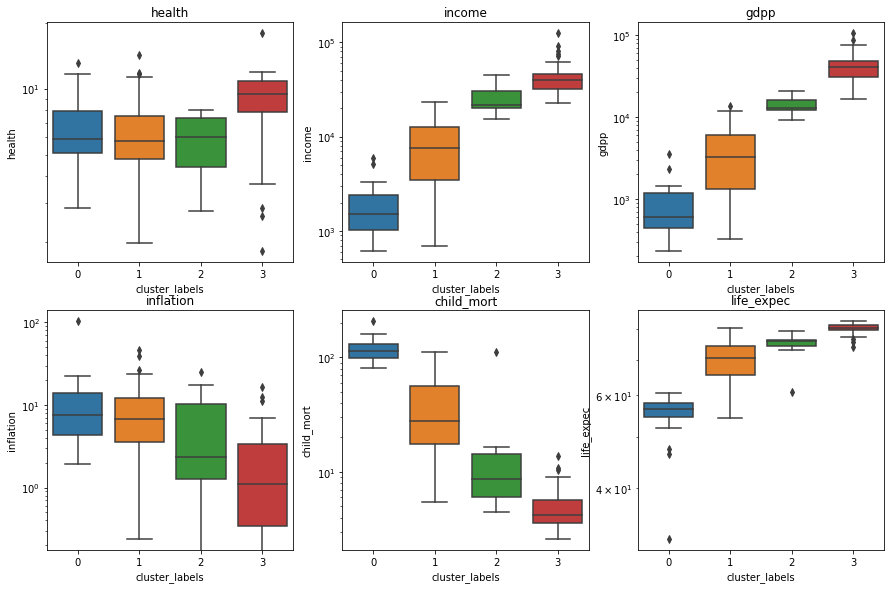

In [515]:
#Understaing the clusters vs Features to determine the charasteristics of the respective Cluster
plt.figure(figsize = (15,15))
feature = ['health','income','gdpp','inflation','child_mort','life_expec']
plt.yscale('log')
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    plt.yscale('log')
    plt.title(i[1])
    sns.boxplot(x='cluster_labels',y=i[1],data=df_kmean)

In [516]:
# Making sense out of the clsuters
df_kmean[['child_mort','gdpp','income','cluster_labels']].groupby('cluster_labels').mean().reset_index()

,cluster_labels,child_mort,gdpp,income
0,0,118.528571,897.190476,1941.095238
1,1,36.827660,4069.180851,8294.680851
2,2,15.937500,14160.625000,26043.750000
3,3,5.144444,42697.222222,45166.666667


- Observation : Cluster 0, represents underdeveloped countries.

In [518]:
df_kmean[df_kmean['cluster_labels'] == 0].sort_values(by = ['gdpp','income','child_mort'], ascending = [True,False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,cluster_labels
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,2,0
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,2,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,2,0
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,2,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,2,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,2,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,2,0
64,Guinea-Bissau,114.0,14.90,8.50,35.2,1390,2.97,55.6,5.05,547,2,0
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.44,56.2,5.82,553,2,0
25,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.81,57.9,5.87,575,2,0


- Recommended Countries - Hierarchical Clustering :
    1. Burundi
    2. Congo, Dem. Rep
    3. Niger
    4. Sierra Leone
    5. Mozambique

- Final Top 5 countries that needs AID : Although the result is almost similar, Choosing H - Clustering over K means as it is more informative than the unstructured set of flat clusters returned by k-‐means 
    1. Burundi
    2. Congo, Dem. Rep
    3. Niger
    4. Sierra Leone
    5. Mozambique